In [1]:
# Step 0: load the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
from sklearn.model_selection import train_test_split
# Remember to setup the code to be device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

%matplotlib inline


cuda


## Let's remember the "standard" PyTorch workflow

1. Process the data into tensors
2. Build the model or use an available one
   * Pick/change a loss function and an optimizer
   * Build a training loop
   * Go back to 2.
3. Fit the model and make predictions based on the input
4. Model evaluation: how did it perform?
5. If it wasn't good enough (likely), improve the model
6. Save the model and test it more data!

## Data preparation and loading

In machine learning, specially in deep learning, data can be almost anything:

- Spreadsheets and tables
- Images
- Videos
- Audio
- DNA
- Text

The main two parts objectives are:

1. Transform data into a numerical representation (tensors)
2. Build a model to find patterns in the numerical representation of the data

As a demonstration, let's create *known* data using the linear regression formula. We'll use this formula to make a straight line using *known* **parameters**

In [2]:
# Define the parameters. In Neural Networks parameters are commonly called weight and intecepts

weight = 0.7 # In linear regression, this would be the slope
bias = 0.3 # In linear regression, this would be the intercept

# Create our variable

start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[0:10], y[0:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

However, just looking at these numbers don't really provide information, ant it benefits greatly from visualization

Text(0, 0.5, 'Y')

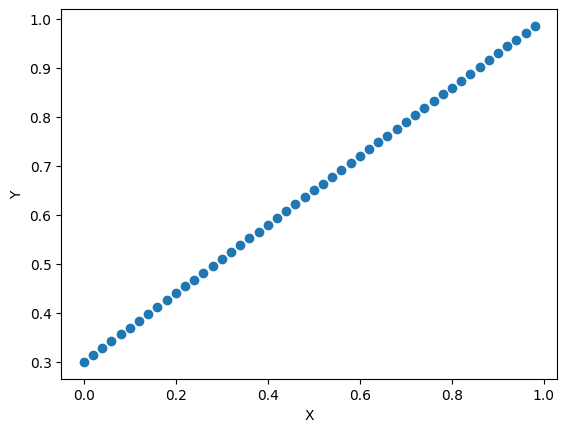

In [3]:
plt.scatter(X,y)
plt.xlabel("X")
plt.ylabel("Y")

## Training and testing datasets

For ML and DL, data is commonly split in training data and testing data, with also validation data a few times.

### Training data
The training data is used to feed model for parameter estimation. Typically it compireses from 60% to 80% of the total data.


### Validation data

This is the only dataset that isn't always used. Works as a sort of practice for the model before working on the testing data for parameter tuning. Usually corresponds to 10% to 20% of the data. 

### Testing data
Testing data is the final step that allows to check if the model is ready for widespread deployment. Depending on the performance on the testing data, it might be necessary to re-start the whole modelling process. Usually corresponds to 10% to 20% of the data. 

### Model generalization
One of the key aspects that we're looking for in our model is generalization. This is the ability of a model to perform well on data it hasn't seen before


In [4]:
# Create a train/test split
train_split = int(0.8*len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# HOWEVER, normally data is split randomly using a library like scikit learn which has an inbuilt function. Don't forget the reproducible randomness!

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=33)


In [5]:
# And we can visualize them, defining a general-purpose function

def plot_prediction(train_data,train_labels,test_data,test_labels,predictions=None):
    
    """
    Plots training data and testing data with their corresponding labels while also plotting the predictions if provided
    """
    # Define figure size
    plt.figure(figsize=(5,3))
    # Plot training and testing data using different colors and labels
    plt.scatter(train_data,train_labels,c='b',s=10,alpha=0.4,label="Training set")
    plt.scatter(test_data,test_labels,c='r',s=10,alpha=0.4,label="Testing set")
    plt.xlabel("Data")
    plt.ylabel("Labels")
    
    # Plot predictions if available
    if predictions is not None:
        plt.scatter(test_data,predictions,c='k',marker='D',s=10,alpha=0.7,label="Predictions")
        
    plt.legend()

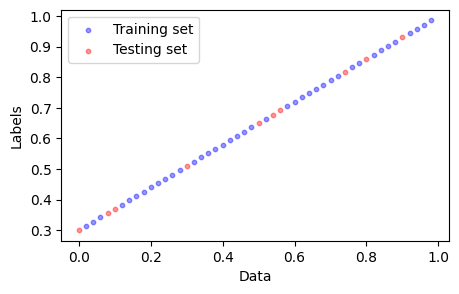

In [6]:
plot_prediction(X_train,y_train,X_test,y_test)


## Model building

In PyTorch, the most common way to build models is constructing the model into a **class**. Using the nn module from PyTorch, we can start our model and then use the training to predict the label values.

What does the model do?
* Start with random values (weight & bias)
* Use the training data to tune the random values to get closer to the ideal values

Using torch.nn we have all the necessary tools:
- torch.nn: Contains all the building blocks for NNs and computational graphs
- torch.nn.Parameters: parameters to be included and tuned in our model. 
- torch.nn.Module: the base class for all NN modules. It can be subclassed, and if done the "forward()" function should be overwritten
- torch.optim: PyTorch optimization functions, mainly invested in gradient descent
- def forward(): How computation happens from one layer to the next. Must be overwritten when subclassing the Module

In [7]:
## It's model time! Remember the linear function y = a + bx

# Create linear regression model class. 

class LinearRegModel(nn.Module): # Almost everything in PyTorch inherits from nn.Module, which is the base class for all Neural Network models
    def __init__(self):
        super().__init__()
        
        # Inititalize model parameters.
        self.weights = nn.Parameter(torch.randn(1),requires_grad = True) # requires_grad is used when the parameter can be updated via gradient descent
        
        self.bias = nn.Parameter(torch.randn(1),requires_grad = True)
        
    # Forward method to define the model computation
    def forward(self, x):# x is the input data
        return self.weights * x + self.bias # The linear regression formula


Gradient descent consists in minimizing a "loss" function. The loss function represents the error between nodes of the neural network, so using gradient descent is a tool to minimize the error in the model.

In [8]:
# Checking the model parameters

# First create a random seed 
torch.manual_seed(33)

# Create an instance of the model (a subclass of our model)

model_0 = LinearRegModel()

# Check out the parameters
list(model_0.parameters())

# Test random parameters
with torch.inference_mode():
    y_preds_random = model_0(X_test)
    
print(y_preds_random.T)

tensor([[-0.2800,  0.2472,  0.4868, -0.0404,  0.5587,  0.6785, -0.3040,  0.1993,
         -0.3998,  0.2712]])


## Fitting the model to the data (training)

The purpose of training is for a model to move from some *unknown* parameters (which can be generated randomly) to *known* parameters. Another way to interpret this is going from a poor representation of the data to a better representation of the data.

A way to measure how good or bad the parameters are is using a **Loss function** (also knwon as cost function or criterion). A loss function measures how wrong the model's predictions are in comparison to to the ground truth labels. The lower the loss, the better performing the model is. PyTorch has multiple loss functions, and they can be better suited for different tasks. For this specific task, we can use the Mean Absolute Error (MAE, nn.L1Loss in PyTorch), which is the mean of the distance between the predicted labels and the true labels.

Model training also requires an **optimizer**. This takes into account the loss of the function in order to tune the parameters and decrease the loss. PyTorch also has many options available in the torch.optim module. Optimizers such as Adam and Stochastic Gradient Descent (SGD) are some of the most popular. But similarly to the loss function, some are better suited for different types of tasks. 

Specifically for PyTorch, we need:
- A training loop
    1. Iteration through the data and do...
    2. Use forward propagation to advance to the next layer. This uses the model's "forward" function
    3. Calculate the loss using our predefined function
    4. Optimizer zero grad
    5. Loss backward - move backwards through the network to calculate each parameter's gradient in respect to the loss
    6. Optimizer step to tune the parameters


- A testing loop

In [9]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer

optim_fn = torch.optim.SGD(params = model_0.parameters(), # We say to use the parameters of our model
                          lr = 0.01) # lr is the 'learning rate' which is set manually by the user. A common value is 0.01. The higher lr, the higher the magnitude of change of the model parameters

torch.manual_seed(33)

# Define the number of epochs, which is the times the data is looped

epochs = 200

# Track different values 
epoch_count = []
train_loss_values = []
test_loss_values = []

# Build the training loop

for epoch in range(epochs):
    
    # Set the model to training mode
    model_0.train()
    
    # Forward pass
    y_pred = model_0(X_train)
    
    # Loss function
    loss = loss_fn(y_pred, y_train)
    
    # Optimizer sero grad
    optim_fn.zero_grad()
    
    # Loss backpropagation
    loss.backward()
    
    # Gradient descent
    optim_fn.step()
    
    
    # Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation or testing
    
    with torch.inference_mode(): # Turns off gradient tracking
        
        # Forward pass
        test_pred = model_0(X_test)
        
        # Loss calculation
        test_loss = loss_fn(test_pred, y_test)
        
    if epoch % 10 == 0: 
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
    
    
# Now try the model

with torch.inference_mode():
    y_preds_new = model_0(X_test)

Epoch: 0 | Loss: 0.4509813189506531 | Test loss: 0.46238765120506287
Epoch: 10 | Loss: 0.32603147625923157 | Test loss: 0.33981040120124817
Epoch: 20 | Loss: 0.22509774565696716 | Test loss: 0.23998494446277618
Epoch: 30 | Loss: 0.18613626062870026 | Test loss: 0.19891339540481567
Epoch: 40 | Loss: 0.16743358969688416 | Test loss: 0.18232238292694092
Epoch: 50 | Loss: 0.15810512006282806 | Test loss: 0.17061638832092285
Epoch: 60 | Loss: 0.15178397297859192 | Test loss: 0.16174013912677765
Epoch: 70 | Loss: 0.14647909998893738 | Test loss: 0.1547551155090332
Epoch: 80 | Loss: 0.1413898468017578 | Test loss: 0.14814850687980652
Epoch: 90 | Loss: 0.13642945885658264 | Test loss: 0.1424897164106369
Epoch: 100 | Loss: 0.13154345750808716 | Test loss: 0.13739962875843048
Epoch: 110 | Loss: 0.12665745615959167 | Test loss: 0.13230952620506287
Epoch: 120 | Loss: 0.12177147716283798 | Test loss: 0.12721940875053406
Epoch: 130 | Loss: 0.11688549816608429 | Test loss: 0.12212929874658585
Epoch: 

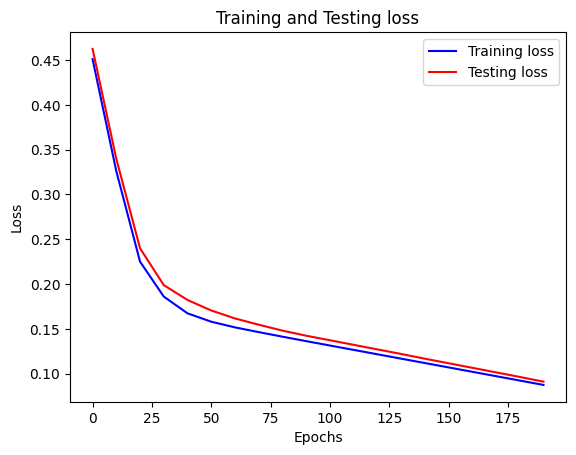

In [10]:
plt.plot(epoch_count,train_loss_values,c='b',label="Training loss")
plt.plot(epoch_count,test_loss_values,c='r',label="Testing loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing loss")
plt.legend()

## Making predictions and evaluating the model (inference)

PyTorch has a function called .inference_mode() that compares the prediction capabilities of our model. It does this comparing the ground truth of our test labels with the values obtained using our model and the test input

Text(0.5, 1.0, 'Prediction using random parameters')

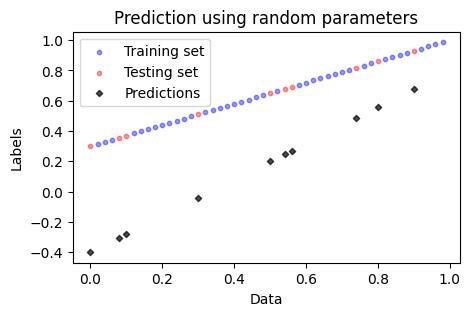

In [11]:

plot_prediction(X_train,y_train,X_test,y_test,predictions=y_preds_random)
plt.title('Prediction using random parameters')

Text(0.5, 1.0, 'Prediction after 200 epochs with a learning rate of 0.01')

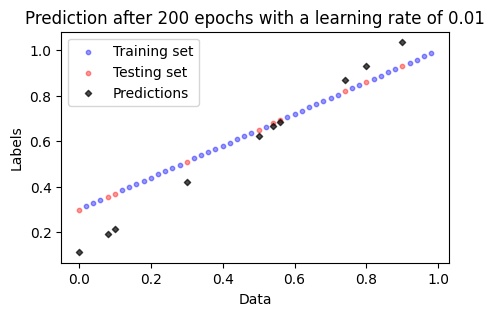

In [12]:
plot_prediction(X_train,y_train,X_test,y_test,predictions=y_preds_new)
plt.title('Prediction after 200 epochs with a learning rate of 0.01')

We can see that after going through the training loop our prediction values are much closer to the truth values

## Saving and reloading the model

After training and validating our model, we can save the model while keeping the parameters so it can be used on new data. In PyTorch, there are three main methods for saving and loading

1. torch.save(): save a model in Python's "pickle" format
2. torch.load(): load a saved PyTorch object
3. torch.nn.Module.load_state_dict: load a model's saved state dictionary.

This last one is the model information of weights and biases that we used in our model prior to the training

Models can be saved in different ways depending if the model will stay only in one notebook or if the objective is to use in external applications

In [33]:
# Saving PyTorch model
from pathlib import Path

# Create model directory
Mods_Path = Path("models")
Mods_Path.mkdir(parents=True,exist_ok=True)

# Create model saveing path
Mod_Name = "01_linear_regression_model.pth" # .pth and .pt are standard PyTorch file extensions
Mod_Saving_Path = Mods_Path / Mod_Name

print(f"Saving path is {Mod_Saving_Path}")

# Save the model state dict
torch.save(obj = model_0.state_dict(), f = Mod_Saving_Path)


Saving path is models/01_linear_regression_model.pth


In [34]:
# You can check proper saving of the model using ls
!ls -l models/

total 24
-rw-r--r-- 1 reyesmatte staffmpi 1203 Jul  6 15:07 01_linear_regression_model.pth


In [35]:
# Loading our PyTorch model
# For this we generate a new instance of our model class, this will have random parameters as opposed to the saved ones post-training

loaded_model_0 = LinearRegModel()

print(f"Initial parameters are {loaded_model_0.state_dict()}")

# And then we load the state_dict of the saved model into our new instance

loaded_model_0.load_state_dict(torch.load(Mod_Saving_Path))

print(f"Updated parameters are {loaded_model_0.state_dict()}")

Initial parameters are OrderedDict([('weights', tensor([-0.0808])), ('bias', tensor([0.7721]))])
Updated parameters are OrderedDict([('weights', tensor([1.0239])), ('bias', tensor([0.1127]))])


In [36]:
# We can now make predictions using our model

loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
    
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

We can see that the resulst of our loaded prediction are all the same as our original prediction!

In this example, loading and saving was done using only the state_dict() of our model. Below is the code necessary to save and load the full model is so desired.

In [37]:
#torch.save(model_0,Mod_Saving_Path)
#loaded_model_0 = torch.load(Mod_Saving_Path)
#loaded_model_0.eval()